In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
from sklearn.model_selection import train_test_split
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
# Constants
NUM_FEATURES = 21
NUM_HIDDEN_LAYER = 10
NUM_CLASSES = 3

learning_rate = 0.01
weight_decay = 1e-6
epochs = 5000
batch_size = 32
num_neurons = 10
seed = 10
np.random.seed(seed)

In [4]:
# Read from CSV
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y-1] = 1 # one hot matrix

In [5]:
# Shuffle
print('Sample size: %d'%(trainX.shape[0]))
s = np.arange(trainX.shape[0]) # Create an index array
np.random.shuffle(s) # Shuffle the index array
trainX, trainY = trainX[s], trainY[s]

Sample size: 2126


In [6]:
# Split into 70:30 (train:test)
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.30, random_state=42)
print(trainX.shape)

(1488, 21)


In [7]:
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Build the graph for the deep net
w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, NUM_HIDDEN_LAYER], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='w1')
b1 = tf.Variable(tf.zeros([NUM_HIDDEN_LAYER]), name='b1')
hidden_relu = tf.nn.relu(tf.matmul(x, w1) + b1, name='relu')

w2 = tf.Variable(tf.truncated_normal([NUM_HIDDEN_LAYER, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_HIDDEN_LAYER))), name='w2')
b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='b2')
logits  = tf.matmul(hidden_relu, w2) + b2

# Apply Softmax activation function to output
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)

# Loss function with L2 Regularization with b = 10^-6
loss1 = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
loss = tf.reduce_mean(loss1 + weight_decay * regularizers)

# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [8]:
# Main
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_acc = []
    test_acc = []
    no_data = trainX.shape[0]
    print('Training dataset: %d' %(no_data))
    
    for i in range(epochs):
        temp_train_acc = 0
        count = 0
        
        for start, end in zip(range(0, no_data, batch_size), range(batch_size, no_data, batch_size)):            
            train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
            temp_train_acc += accuracy.eval(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
            count += 1
            
        train_acc.append(temp_train_acc/count) # Mean training accuracy of all batches
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))

        if i % 100 == 0:
            print('Iter: %d | Train acc: %g | Test acc: %g'%(i, train_acc[i], test_acc[i]))

Training dataset: 1488
Iter: 0 | Train acc: 0.548913 | Test acc: 0.782132
Iter: 100 | Train acc: 0.867527 | Test acc: 0.851097
Iter: 200 | Train acc: 0.883832 | Test acc: 0.880878
Iter: 300 | Train acc: 0.892663 | Test acc: 0.888715
Iter: 400 | Train acc: 0.894701 | Test acc: 0.89185
Iter: 500 | Train acc: 0.901495 | Test acc: 0.893417
Iter: 600 | Train acc: 0.904212 | Test acc: 0.899687
Iter: 700 | Train acc: 0.905571 | Test acc: 0.899687
Iter: 800 | Train acc: 0.906929 | Test acc: 0.896552
Iter: 900 | Train acc: 0.906929 | Test acc: 0.894984
Iter: 1000 | Train acc: 0.907609 | Test acc: 0.894984
Iter: 1100 | Train acc: 0.908967 | Test acc: 0.893417
Iter: 1200 | Train acc: 0.908967 | Test acc: 0.894984
Iter: 1300 | Train acc: 0.908288 | Test acc: 0.893417
Iter: 1400 | Train acc: 0.908967 | Test acc: 0.890282
Iter: 1500 | Train acc: 0.911685 | Test acc: 0.89185
Iter: 1600 | Train acc: 0.911005 | Test acc: 0.893417
Iter: 1700 | Train acc: 0.911005 | Test acc: 0.893417
Iter: 1800 | Train 

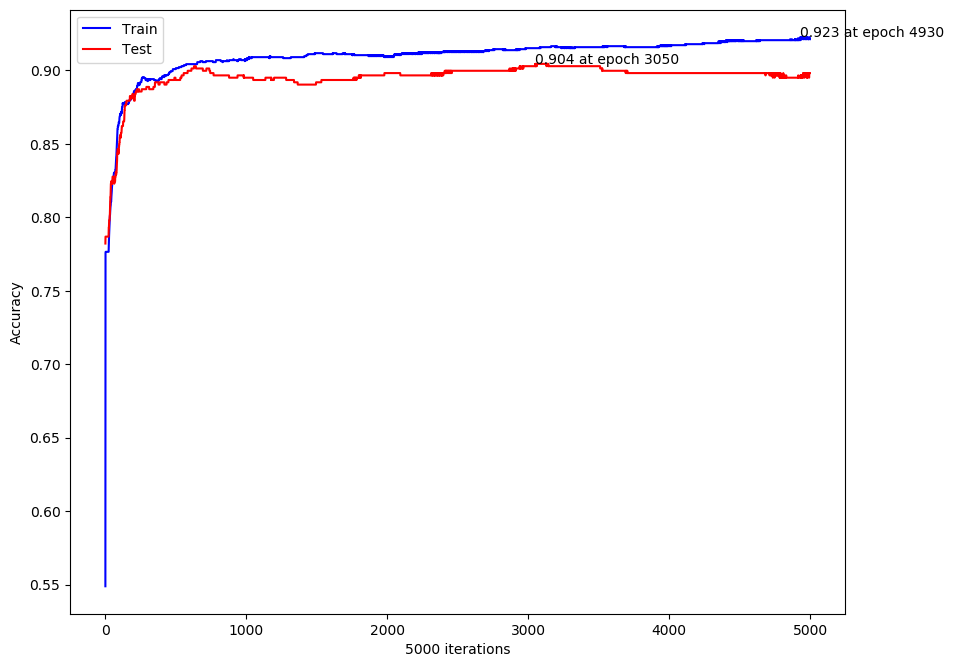

In [9]:
# Plot learning curves
plt.figure(1, figsize=(10, 8), dpi= 100)

plt.plot(range(epochs), train_acc, color='blue', label='Train')
maxTrain = max(train_acc)
maxTrainIndex = train_acc.index(maxTrain)
plt.text(maxTrainIndex, maxTrain, "%.3f at epoch %d" %(maxTrain, maxTrainIndex))

plt.plot(range(epochs), test_acc, color='red', label='Test')
maxTest = max(test_acc)
maxTestIndex = test_acc.index(maxTest)
plt.text(maxTestIndex, maxTest, "%.3f at epoch %d" %(maxTest, maxTestIndex))

plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('PartA_Qn1a.png')
plt.show()